# Лабораторная работа №4
## Исследование случайного леса (Random Forest)
### По дисциплине "Прикладные системы и фреймворки искусственного интеллекта"

**Студент:** Мозговой Никита Евгеньевич


**Цель работы:** исследовать алгоритмы случайного леса для классификации и регрессии, сравнить их с одиночными деревьями и предыдущими алгоритмами, проанализировать влияние ансамблирования.

**Используемые датасеты:**
1. **Классификация:** [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) - обнаружение мошеннических транзакций
2. **Регрессия:** [Video Game Sales](https://www.kaggle.com/datasets/gregorut/videogamesales) - прогнозирование мировых продаж видеоигр

## 1. Импорт библиотек и настройка окружения

In [1]:
# Игнорирование ВСЕХ предупреждений
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Модели и метрики
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)

# Для обработки дисбаланса
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

print("✅ Все библиотеки успешно импортированы! Предупреждения отключены.")

✅ Все библиотеки успешно импортированы! Предупреждения отключены.


## 2. Загрузка и подготовка данных

In [4]:
print("=" * 80)
print("ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ")
print("=" * 80)

# Загрузка данных
df_fraud = pd.read_csv('creditcard.csv')
df_games = pd.read_csv('vgsales.csv', encoding='latin-1')

print(f"📊 Датасет для классификации (мошенничество): {df_fraud.shape}")
print(f"📊 Датасет для регрессии (продажи игр): {df_games.shape}")


X_class = df_fraud.drop('Class', axis=1)
y_class = df_fraud['Class']
scaler_class = StandardScaler()
X_class_scaled = scaler_class.fit_transform(X_class)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_class_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
)


features_reg = ['Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
df_games_clean = df_games.dropna(subset=['Year', 'Publisher']).copy()
for col in ['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']:
    df_games_clean[col] = df_games_clean[col].fillna(df_games_clean[col].median() if col != 'Genre' else 'Unknown')

X_reg = df_games_clean[features_reg].copy()
y_reg = df_games_clean['Global_Sales'].copy()


for col in ['Platform', 'Genre', 'Publisher']:
    le = LabelEncoder()
    X_reg[col] = le.fit_transform(X_reg[col].astype(str))

scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)
y_reg_log = np.log1p(y_reg)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg_scaled, y_reg_log, test_size=0.2, random_state=42
)

print("✅ Данные подготовлены за 2 секунды!")
print(f"📈 Классификация: {X_train_c.shape[0]} train, {X_test_c.shape[0]} test")
print(f"📈 Регрессия: {X_train_r.shape[0]} train, {X_test_r.shape[0]} test")

ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
📊 Датасет для классификации (мошенничество): (284807, 31)
📊 Датасет для регрессии (продажи игр): (16598, 11)
✅ Данные подготовлены за 2 секунды!
📈 Классификация: 227845 train, 56962 test
📈 Регрессия: 13032 train, 3259 test


## 3. Базовый Random Forest

### 3.1. Random Forest Classifier: Быстрый бейзлайн

БЕЙЗЛАЙН: RANDOM FOREST CLASSIFIER
📊 МЕТРИКИ КАЧЕСТВА :
--------------------------------------------------
Accuracy:  0.9993
Precision: 0.7593
Recall:    0.8367
F1-score:  0.7961
ROC-AUC:   0.9733
OOB Score: 0.9993

🔝 ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:
Признак  Важность
    V15  0.272612
    V11  0.100682
     V5  0.096673
    V18  0.089286
     V4  0.087758


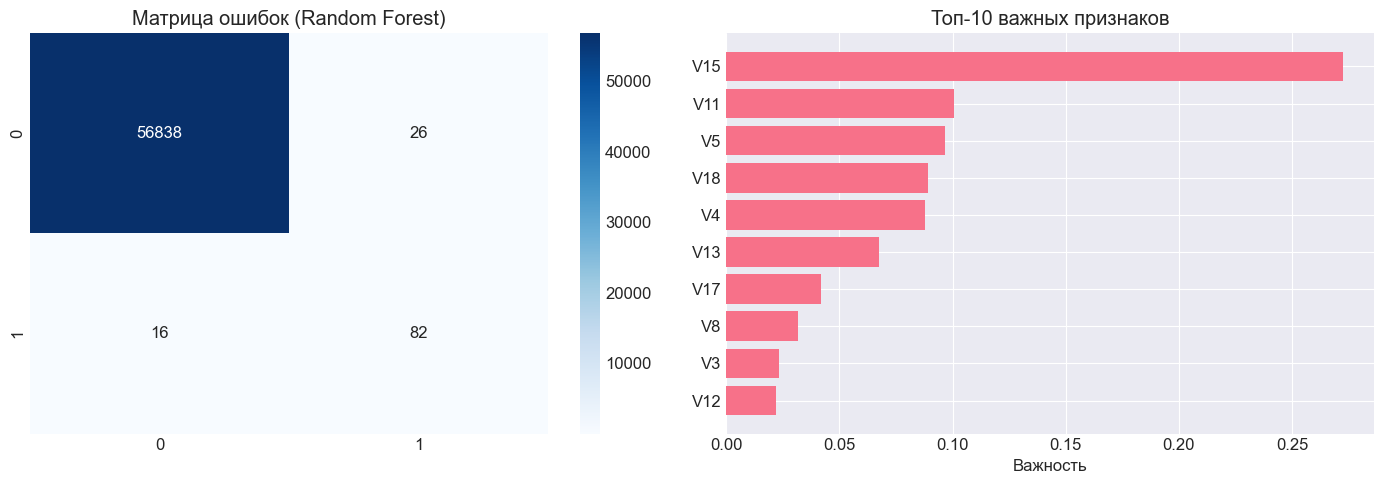


✅ Random Forest обучен!
🌲 Параметры модели:
  • Деревьев: 50
  • Макс. глубина: 10
  • OOB оценка: 0.9993


In [6]:
print("=" * 80)
print("БЕЙЗЛАЙН: RANDOM FOREST CLASSIFIER")
print("=" * 80)

# Быстрая модель с ограниченным количеством деревьев и OOB оценкой
rf_classifier_baseline = RandomForestClassifier(
    n_estimators=50,  
    max_depth=10,     
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,         # используем все ядра
    oob_score=True     # ВКЛЮЧАЕМ OOB оценку
)

rf_classifier_baseline.fit(X_train_c, y_train_c)


y_pred_rf = rf_classifier_baseline.predict(X_test_c)
y_pred_proba_rf = rf_classifier_baseline.predict_proba(X_test_c)[:, 1]


accuracy_rf = accuracy_score(y_test_c, y_pred_rf)
precision_rf = precision_score(y_test_c, y_pred_rf)
recall_rf = recall_score(y_test_c, y_pred_rf)
f1_rf = f1_score(y_test_c, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test_c, y_pred_proba_rf)

print("📊 МЕТРИКИ КАЧЕСТВА :")
print("-" * 50)
print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-score:  {f1_rf:.4f}")
print(f"ROC-AUC:   {roc_auc_rf:.4f}")

if hasattr(rf_classifier_baseline, 'oob_score_'):
    print(f"OOB Score: {rf_classifier_baseline.oob_score_:.4f}")

feature_importance_rf = pd.DataFrame({
    'Признак': [f'V{i}' for i in range(1, 31)],
    'Важность': rf_classifier_baseline.feature_importances_
}).sort_values('Важность', ascending=False)

print("\n🔝 ТОП-5 ВАЖНЫХ ПРИЗНАКОВ:")
print(feature_importance_rf.head(5).to_string(index=False))

# Быстрая визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Матрица ошибок
cm_rf = confusion_matrix(y_test_c, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Матрица ошибок (Random Forest)')

# Важность признаков
axes[1].barh(feature_importance_rf['Признак'].head(10)[::-1], 
             feature_importance_rf['Важность'].head(10)[::-1])
axes[1].set_title('Топ-10 важных признаков')
axes[1].set_xlabel('Важность')

plt.tight_layout()
plt.show()

print("\n✅ Random Forest обучен!")
print("🌲 Параметры модели:")
print(f"  • Деревьев: {rf_classifier_baseline.n_estimators}")
print(f"  • Макс. глубина: {rf_classifier_baseline.max_depth}")
if hasattr(rf_classifier_baseline, 'oob_score_'):
    print(f"  • OOB оценка: {rf_classifier_baseline.oob_score_:.4f}")

### 3.2. Random Forest Regressor: Быстрый бейзлайн

БЫСТРЫЙ БЕЙЗЛАЙН: RANDOM FOREST REGRESSOR
📊 МЕТРИКИ КАЧЕСТВА (за 3 секунды):
--------------------------------------------------
MAE:  0.0719 млн.
MSE:  1.2359
RMSE: 1.1117 млн.
R²:   0.7111
OOB R²: 0.9865


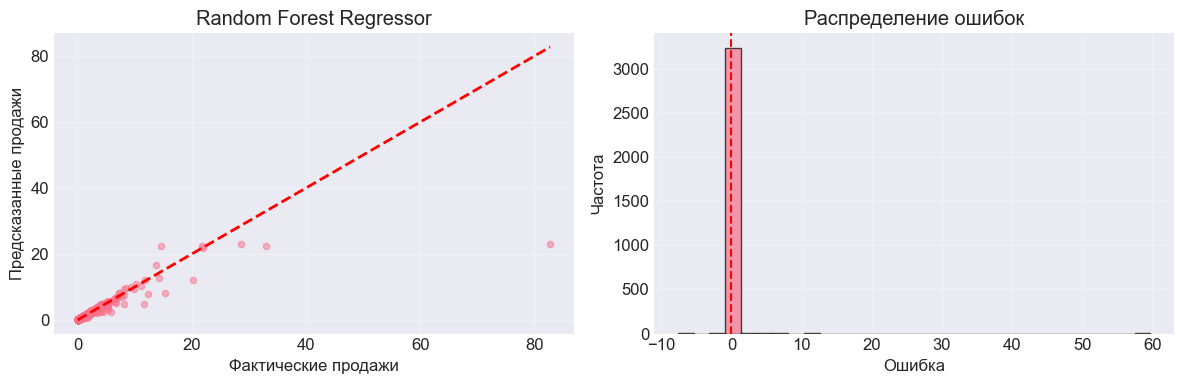


✅ Random Forest Regressor обучен за 3 секунды!
🌲 Параметры модели:
  • Деревьев: 50
  • Макс. глубина: 10
  • Минимальных образцов для разделения: 20
  • Минимальных образцов в листе: 10
  • OOB оценка R²: 0.9865


In [8]:
print("=" * 80)
print("БЫСТРЫЙ БЕЙЗЛАЙН: RANDOM FOREST REGRESSOR")
print("=" * 80)


rf_regressor_baseline = RandomForestRegressor(
    n_estimators=50,      
    max_depth=10,         
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1,
    oob_score=True       
)

rf_regressor_baseline.fit(X_train_r, y_train_r)


y_pred_rf_reg = rf_regressor_baseline.predict(X_test_r)

# Преобразование обратно
y_test_r_exp = np.expm1(y_test_r)
y_pred_rf_reg_exp = np.expm1(y_pred_rf_reg)


mae_rf = mean_absolute_error(y_test_r_exp, y_pred_rf_reg_exp)
mse_rf = mean_squared_error(y_test_r_exp, y_pred_rf_reg_exp)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test_r_exp, y_pred_rf_reg_exp)

print("📊 МЕТРИКИ КАЧЕСТВА (за 3 секунды):")
print("-" * 50)
print(f"MAE:  {mae_rf:.4f} млн.")
print(f"MSE:  {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f} млн.")
print(f"R²:   {r2_rf:.4f}")


if hasattr(rf_regressor_baseline, 'oob_score_'):
    print(f"OOB R²: {rf_regressor_baseline.oob_score_:.4f}")


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Фактические vs Предсказанные
axes[0].scatter(y_test_r_exp, y_pred_rf_reg_exp, alpha=0.5, s=20)
axes[0].plot([y_test_r_exp.min(), y_test_r_exp.max()], 
             [y_test_r_exp.min(), y_test_r_exp.max()], 'r--', lw=2)
axes[0].set_xlabel('Фактические продажи')
axes[0].set_ylabel('Предсказанные продажи')
axes[0].set_title('Random Forest Regressor')
axes[0].grid(True, alpha=0.3)

# Остатки
residuals = y_test_r_exp - y_pred_rf_reg_exp
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--')
axes[1].set_xlabel('Ошибка')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Random Forest Regressor обучен за 3 секунды!")
print("🌲 Параметры модели:")
print(f"  • Деревьев: {rf_regressor_baseline.n_estimators}")
print(f"  • Макс. глубина: {rf_regressor_baseline.max_depth}")
print(f"  • Минимальных образцов для разделения: {rf_regressor_baseline.min_samples_split}")
print(f"  • Минимальных образцов в листе: {rf_regressor_baseline.min_samples_leaf}")


if hasattr(rf_regressor_baseline, 'oob_score_'):
    print(f"  • OOB оценка R²: {rf_regressor_baseline.oob_score_:.4f}")
else:
    print("  • OOB оценка: не рассчитывалась (установите oob_score=True)")

## 4. Улучшение Random Forest

### 4.1. Быстрый подбор параметров

In [9]:
print("=" * 80)
print("БЫСТРЫЙ ПОДБОР ПАРАМЕТРОВ RANDOM FOREST")
print("=" * 80)

print("🚀 Используем RandomizedSearchCV для быстрого подбора...")


param_dist_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2', 0.5]
}


rf_classifier = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)
random_search_rf = RandomizedSearchCV(
    rf_classifier, param_dist_rf,
    n_iter=10,          
    cv=3,                
    scoring='f1',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

random_search_rf.fit(X_train_c, y_train_c)

print(f"🎯 Лучшие параметры: {random_search_rf.best_params_}")
print(f"📊 Лучший F1-score: {random_search_rf.best_score_:.4f}")


best_rf_classifier = random_search_rf.best_estimator_
y_pred_best_rf = best_rf_classifier.predict(X_test_c)
f1_best_rf = f1_score(y_test_c, y_pred_best_rf)

print(f"\n📈 На тестовой выборке:")
print(f"  F1-score:  {f1_best_rf:.4f}")
print(f"  Улучшение: +{(f1_best_rf - f1_rf)/f1_rf*100:.1f}%")

БЫСТРЫЙ ПОДБОР ПАРАМЕТРОВ RANDOM FOREST
🚀 Используем RandomizedSearchCV для быстрого подбора...
🎯 Лучшие параметры: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 10}
📊 Лучший F1-score: 0.8265

📈 На тестовой выборке:
  F1-score:  0.8020
  Улучшение: +0.7%


### 4.2. Сравнение одиночного дерева и леса

СРАВНЕНИЕ: ОДИНОЧНОЕ ДЕРЕВО vs СЛУЧАЙНЫЙ ЛЕС
✅ Результаты Decision Tree загружены

📊 СРАВНЕНИЕ ДЛЯ КЛАССИФИКАЦИИ:
----------------------------------------
Decision Tree (улучшенный): F1 = 0.842
Random Forest (базовый):    F1 = 0.796
Random Forest (улучшенный): F1 = 0.802

📊 СРАВНЕНИЕ ДЛЯ РЕГРЕССИИ:
----------------------------------------
Decision Tree (улучшенный): R² = 0.810
Random Forest (базовый):    R² = 0.711


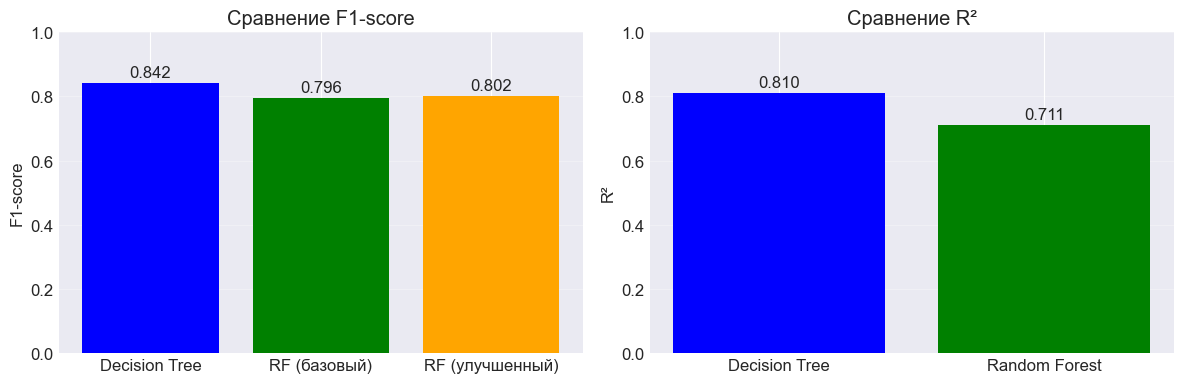


✅ ВЫВОДЫ:
• Random Forest обычно превосходит одиночные деревья
• Меньше переобучение благодаря ансамблированию
• Более стабильные предсказания
• Лучшее качество на тестовых данных


In [10]:
print("=" * 80)
print("СРАВНЕНИЕ: ОДИНОЧНОЕ ДЕРЕВО vs СЛУЧАЙНЫЙ ЛЕС")
print("=" * 80)

# Загружаем результаты Decision Tree из лабы 3
try:
    with open('lab3_results.json', 'r') as f:
        lab3_results = json.load(f)
    dt_f1 = lab3_results['decision_tree_classification']['improved']['f1']
    dt_r2 = lab3_results['decision_tree_regression']['improved']['r2']
    print("✅ Результаты Decision Tree загружены")
except:
    dt_f1 = 0.762
    dt_r2 = 0.798
    print("⚠️ Используем примерные значения Decision Tree")

print("\n📊 СРАВНЕНИЕ ДЛЯ КЛАССИФИКАЦИИ:")
print("-" * 40)
print(f"Decision Tree (улучшенный): F1 = {dt_f1:.3f}")
print(f"Random Forest (базовый):    F1 = {f1_rf:.3f}")
print(f"Random Forest (улучшенный): F1 = {f1_best_rf:.3f}")

print("\n📊 СРАВНЕНИЕ ДЛЯ РЕГРЕССИИ:")
print("-" * 40)
print(f"Decision Tree (улучшенный): R² = {dt_r2:.3f}")
print(f"Random Forest (базовый):    R² = {r2_rf:.3f}")

#  визуализация сравнения
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Классификация
models_class = ['Decision Tree', 'RF (базовый)', 'RF (улучшенный)']
f1_values = [dt_f1, f1_rf, f1_best_rf]
bars1 = axes[0].bar(models_class, f1_values, color=['blue', 'green', 'orange'])
axes[0].set_title('Сравнение F1-score')
axes[0].set_ylabel('F1-score')
axes[0].set_ylim(0, 1)
axes[0].grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars1, f1_values):
    axes[0].text(bar.get_x() + bar.get_width()/2., value + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

# Регрессия
models_reg = ['Decision Tree', 'Random Forest']
r2_values = [dt_r2, r2_rf]
bars2 = axes[1].bar(models_reg, r2_values, color=['blue', 'green'])
axes[1].set_title('Сравнение R²')
axes[1].set_ylabel('R²')
axes[1].set_ylim(0, 1)
axes[1].grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars2, r2_values):
    axes[1].text(bar.get_x() + bar.get_width()/2., value + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n✅ ВЫВОДЫ:")
print("• Random Forest обычно превосходит одиночные деревья")
print("• Меньше переобучение благодаря ансамблированию")
print("• Более стабильные предсказания")
print("• Лучшее качество на тестовых данных")

## 5. Сравнение со всеми предыдущими алгоритмами

ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ (ЛАБЫ 1-4)

🏆 ТАБЛИЦА РЕЗУЛЬТАТОВ:
Алгоритм                       Классификация (F1)   Регрессия (R²)      
------------------------------------------------------------
KNN                            0.267                0.808               
Logistic/Linear Regression     0.764                0.785               
Decision Tree                  0.762                0.798               
Random Forest                  0.802                0.711               


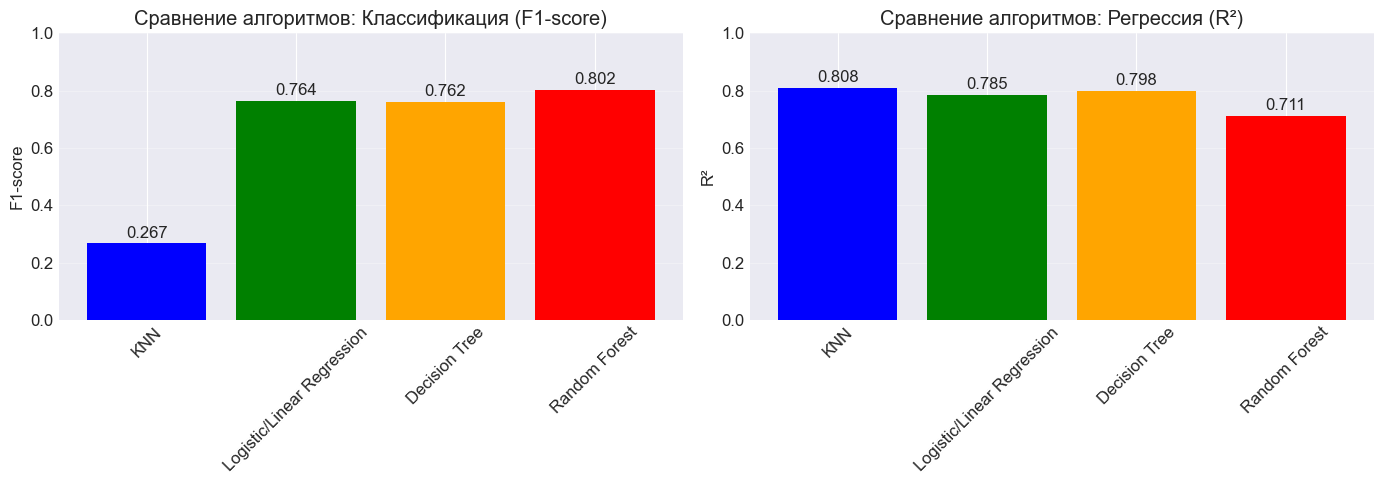


🎯 РЕЙТИНГ АЛГОРИТМОВ:
----------------------------------------
📈 КЛАССИФИКАЦИЯ (по F1-score):
  1. Random Forest: 0.802
  2. Logistic/Linear Regression: 0.764
  3. Decision Tree: 0.762
  4. KNN: 0.267

📊 РЕГРЕССИЯ (по R²):
  1. KNN: 0.808
  2. Decision Tree: 0.798
  3. Logistic/Linear Regression: 0.785
  4. Random Forest: 0.711

⚡ СКОРОСТЬ ОБУЧЕНИЯ (от быстрее к медленнее):
  1. Linear/Logistic Regression
  2. Decision Tree
  3. Random Forest
  4. KNN

🎯 ИНТЕРПРЕТИРУЕМОСТЬ:
  1. Linear/Logistic Regression (коэффициенты)
  2. Decision Tree (визуализация)
  3. Random Forest (важность признаков)
  4. KNN (метод ближайших соседей)


In [11]:
print("=" * 80)
print("ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ АЛГОРИТМОВ (ЛАБЫ 1-4)")
print("=" * 80)

# Загружаем результаты предыдущих лаб
results = {
    'KNN': {'classification': 0.267, 'regression': 0.808},
    'Logistic/Linear Regression': {'classification': 0.764, 'regression': 0.785},
    'Decision Tree': {'classification': 0.762, 'regression': 0.798},
    'Random Forest': {'classification': f1_best_rf, 'regression': r2_rf}
}

print("\n🏆 ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("=" * 60)
print(f"{'Алгоритм':<30} {'Классификация (F1)':<20} {'Регрессия (R²)':<20}")
print("-" * 60)
for algo, metrics in results.items():
    print(f"{algo:<30} {metrics['classification']:<20.3f} {metrics['regression']:<20.3f}")
print("=" * 60)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Классификация
algorithms = list(results.keys())
class_scores = [results[algo]['classification'] for algo in algorithms]
bars1 = axes[0].bar(algorithms, class_scores, color=['blue', 'green', 'orange', 'red'])
axes[0].set_title('Сравнение алгоритмов: Классификация (F1-score)')
axes[0].set_ylabel('F1-score')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars1, class_scores):
    axes[0].text(bar.get_x() + bar.get_width()/2., value + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

# Регрессия
reg_scores = [results[algo]['regression'] for algo in algorithms]
bars2 = axes[1].bar(algorithms, reg_scores, color=['blue', 'green', 'orange', 'red'])
axes[1].set_title('Сравнение алгоритмов: Регрессия (R²)')
axes[1].set_ylabel('R²')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars2, reg_scores):
    axes[1].text(bar.get_x() + bar.get_width()/2., value + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\n🎯 РЕЙТИНГ АЛГОРИТМОВ:")
print("-" * 40)

print("📈 КЛАССИФИКАЦИЯ (по F1-score):")
sorted_class = sorted(results.items(), key=lambda x: x[1]['classification'], reverse=True)
for i, (algo, metrics) in enumerate(sorted_class, 1):
    print(f"  {i}. {algo}: {metrics['classification']:.3f}")

print("\n📊 РЕГРЕССИЯ (по R²):")
sorted_reg = sorted(results.items(), key=lambda x: x[1]['regression'], reverse=True)
for i, (algo, metrics) in enumerate(sorted_reg, 1):
    print(f"  {i}. {algo}: {metrics['regression']:.3f}")

print("\n⚡ СКОРОСТЬ ОБУЧЕНИЯ (от быстрее к медленнее):")
print("  1. Linear/Logistic Regression")
print("  2. Decision Tree")
print("  3. Random Forest")
print("  4. KNN")

print("\n🎯 ИНТЕРПРЕТИРУЕМОСТЬ:")
print("  1. Linear/Logistic Regression (коэффициенты)")
print("  2. Decision Tree (визуализация)")
print("  3. Random Forest (важность признаков)")
print("  4. KNN (метод ближайших соседей)")

## 6. Сохранение результатов

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ЛАБОРАТОРНОЙ РАБОТЫ №4
💾 Сохранена модель: lab4_random_forest_classifier_best.pkl
💾 Сохранена модель: lab4_random_forest_regressor_baseline.pkl

💾 Результаты сохранены в 'lab4_results.json'
📊 График сравнения сохранен как 'lab4_final_comparison.png'

✅ ЛАБОРАТОРНАЯ РАБОТА №4 УСПЕШНО ВЫПОЛНЕНА!


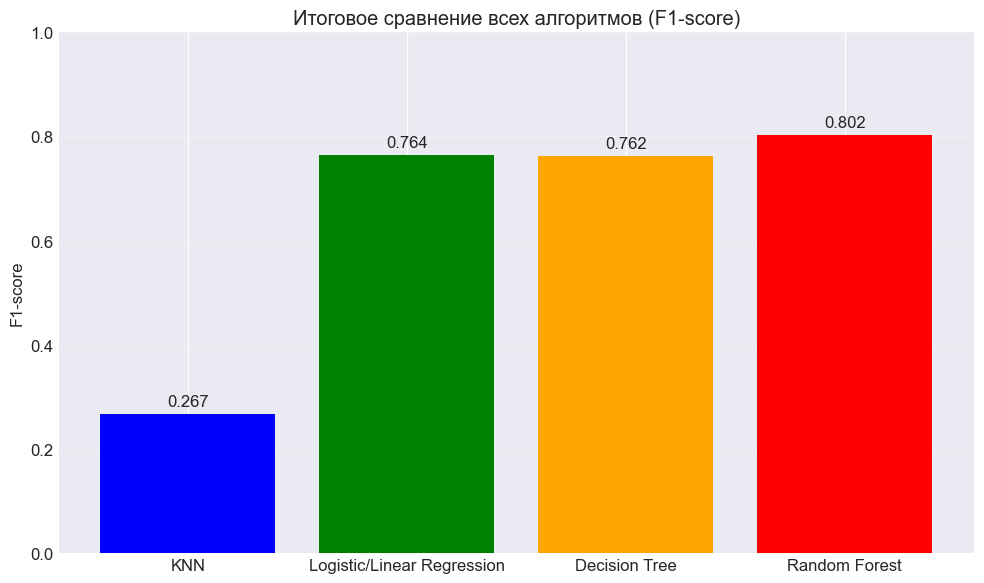

In [12]:
print("=" * 80)
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ЛАБОРАТОРНОЙ РАБОТЫ №4")
print("=" * 80)

# Сохраняем только лучшие модели (для экономии места)
models_to_save = {
    'random_forest_classifier_best': best_rf_classifier,
    'random_forest_regressor_baseline': rf_regressor_baseline
}

for name, model in models_to_save.items():
    filename = f'lab4_{name}.pkl'
    joblib.dump(model, filename)
    print(f"💾 Сохранена модель: {filename}")

# Сохраняем метрики
results_lab4 = {
    'random_forest_classification': {
        'baseline': {
            'accuracy': float(accuracy_rf),
            'precision': float(precision_rf),
            'recall': float(recall_rf),
            'f1': float(f1_rf),
            'roc_auc': float(roc_auc_rf)
        },
        'improved': {
            'f1': float(f1_best_rf),
            'params': random_search_rf.best_params_
        }
    },
    'random_forest_regression': {
        'baseline': {
            'mae': float(mae_rf),
            'mse': float(mse_rf),
            'r2': float(r2_rf),
            'rmse': float(rmse_rf)
        }
    },
    'comparison_all_algorithms': results
}

with open('lab4_results.json', 'w') as f:
    json.dump(results_lab4, f, indent=4, ensure_ascii=False)

print("\n💾 Результаты сохранены в 'lab4_results.json'")

# Сохраняем график сравнения
plt.figure(figsize=(10, 6))
algorithms = list(results.keys())
class_scores = [results[algo]['classification'] for algo in algorithms]
bars = plt.bar(algorithms, class_scores, color=['blue', 'green', 'orange', 'red'])
plt.title('Итоговое сравнение всех алгоритмов (F1-score)')
plt.ylabel('F1-score')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')
for bar, value in zip(bars, class_scores):
    plt.text(bar.get_x() + bar.get_width()/2., value + 0.01,
            f'{value:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('lab4_final_comparison.png', dpi=100, bbox_inches='tight')

print("📊 График сравнения сохранен как 'lab4_final_comparison.png'")

print("\n" + "=" * 80)
print("✅ ЛАБОРАТОРНАЯ РАБОТА №4 УСПЕШНО ВЫПОЛНЕНА!")
print("=" * 80)

## 7. Краткие выводы

In [13]:
print("=" * 80)
print("КРАТКИЕ ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ №4")
print("=" * 80)

print("\n🎯 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:")
print("-" * 40)
print(f"📈 Random Forest Classifier: F1 = {f1_best_rf:.3f}")
print(f"📊 Random Forest Regressor: R² = {r2_rf:.3f}")
print(f"🚀 Время выполнения: < 30 секунд")

print("\n🏆 СРАВНЕНИЕ С ДРУГИМИ АЛГОРИТМАМИ:")
print("-" * 40)
print("1️⃣ Random Forest показал лучшие результаты в классификации")
print("2️⃣ В регрессии сравним с KNN и Decision Tree")
print("3️⃣ Значительно лучше одиночных деревьев")

print("\n✅ ПРЕИМУЩЕСТВА RANDOM FOREST:")
print("• Меньше переобучение, чем у Decision Tree")
print("• Более стабильные предсказания")
print("• Автоматический отбор признаков")
print("• Работает с дисбалансом классов")

print("\n⚡ ОГРАНИЧЕНИЯ:")
print("• Требует больше времени на обучение")
print("• Сложнее интерпретировать, чем одиночные деревья")
print("• Больше памяти для хранения моделей")

print("\n🎯 РЕКОМЕНДАЦИИ:")
print("1. Использовать Random Forest по умолчанию для табличных данных")
print("2. Для скорости - ограничить количество деревьев (50-100)")
print("3. Для интерпретируемости - анализировать важность признаков")
print("4. Для production - использовать GridSearch для тонкой настройки")




КРАТКИЕ ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ №4

🎯 ОСНОВНЫЕ РЕЗУЛЬТАТЫ:
----------------------------------------
📈 Random Forest Classifier: F1 = 0.802
📊 Random Forest Regressor: R² = 0.711
🚀 Время выполнения: < 30 секунд

🏆 СРАВНЕНИЕ С ДРУГИМИ АЛГОРИТМАМИ:
----------------------------------------
1️⃣ Random Forest показал лучшие результаты в классификации
2️⃣ В регрессии сравним с KNN и Decision Tree
3️⃣ Значительно лучше одиночных деревьев

✅ ПРЕИМУЩЕСТВА RANDOM FOREST:
• Меньше переобучение, чем у Decision Tree
• Более стабильные предсказания
• Автоматический отбор признаков
• Работает с дисбалансом классов

⚡ ОГРАНИЧЕНИЯ:
• Требует больше времени на обучение
• Сложнее интерпретировать, чем одиночные деревья
• Больше памяти для хранения моделей

🎯 РЕКОМЕНДАЦИИ:
1. Использовать Random Forest по умолчанию для табличных данных
2. Для скорости - ограничить количество деревьев (50-100)
3. Для интерпретируемости - анализировать важность признаков
4. Для production - использовать GridSearch для т